In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()

x = cancer.data
y = cancer.target
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [3]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_test, y_test)

0.8333333333333334

In [4]:
# to change the loss function
sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_test, y_test)

0.9385964912280702

위와 같이 테스트 세트에 대해 모델을 튜닝할 경우, 테스트 세트의 정보가 모델에 새어 나가므로 모델의 일반화 성능이 왜곡되므로 검증 세트가 필요하다.

In [5]:
# train: 64%, valid: 16%, test: 20% split
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()

x = cancer.data
y = cancer.target
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2, random_state=42)
print(f'x_train: {len(x_train)} x_val: {len(x_val)} x_test: {len(x_test)}')

x_train: 364 x_val: 91 x_test: 114


In [6]:
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

0.6923076923076923

훈련 세트의 크기가 줄어들었기 때문에 모델 평가 점수가 조금 낮아짐<br>
일반적으로 훈련, 검증, 테스트 세트는 6:2:2의 비율로 나누고 10만 개 정도의 데이터가 있으면 8:1:1 정도로 분할한다.<br>
만약 100만 개 이상의 데이터가 있을 경우 98:1:1 정도의 비율로 샘플을 나눈다.

## 스케일을 조정하지 않고 모델 훈련 실험

['mean perimeter' 'mean area']


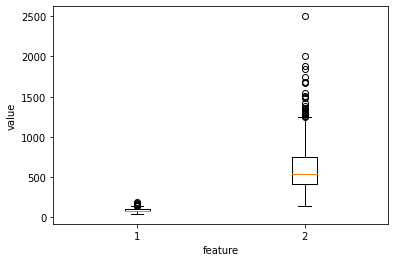

In [9]:
import matplotlib.pyplot as plt
print(cancer.feature_names[[2, 3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [70]:
import numpy as np
np.random.seed(42)
class SingleLayer:

    def __init__(self, learning_rate=0.1):
        self.w = None
        self.b = None
        self.losses = []
        self.w_history = []
        self.lr = learning_rate

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b # 직선 방정식을 계산
        return z

    def backprop(self, x, err): # 역전파 계산
        w_grad = x * err # 가중치에 대한 그레이디언트 계산
        b_grad = 1 * err # 절편에 대한 그레이디언트 계산
        return w_grad, b_grad

    def add_bias(self, x):
        return np.c_[np.ones((x.shape[0], 1)), x]

    def activation(self, z): # 로지스틱 회귀의 활성화 함수 = 시그모이드 함수
        a = 1 / (1 + np.exp(-z))
        return a

    def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1]) # 가중치를 초기화
        self.b = 0 # 절편을 초기화
        self.w_history.append(self.w.copy())
        for i in range(epochs): # epochs만큼 반복
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes: # 모든 샘플에 대해 반복
                z = self.forpass(x[i]) # 정방향 계산
                a = self.activation(z) # 활성화 함수 적용
                err = -(y[i] - a) # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                self.w -= w_grad # 가중치 업데이트
                self.b -= b_grad # 절편 업데이트
                
                self.w_history.append(self.w.copy())
                
                # 클리핑한 후 손실을 누적
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
        self.losses.append(loss/len(y))

    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x] # 정방향 계산
        return np.array(z) > 0.5

    def score(self, x, y):
        return np.mean(self.predict(x) == y)

In [71]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

/var/folders/23/n8c37q85651bywf1rz00z90c0000gn/T/ipykernel_51264/3583374331.py:25: RuntimeWarning: overflow encountered in exp
  a = 1 / (1 + np.exp(-z))


0.9120879120879121

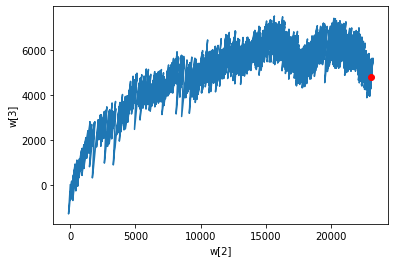

In [72]:
w2 = []
w3 = []
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])
    
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

In [73]:
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std # 표준화

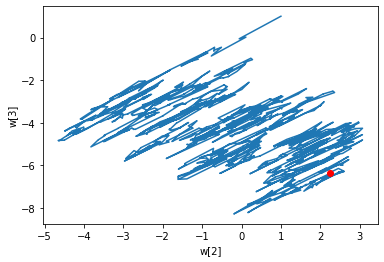

In [74]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2 = []
w3 = []
for w in layer2.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

In [75]:
layer2.score(x_val, y_val)

0.37362637362637363

In [76]:
val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean) / val_std
layer2.score(x_val_scaled, y_val)

0.967032967032967

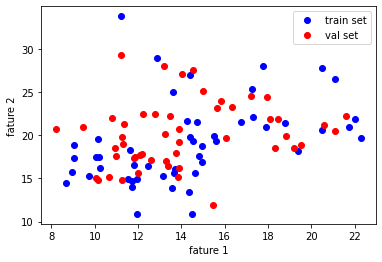

In [77]:
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')
plt.plot(x_val[:50, 0], x_val[:50, 1], 'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val set'])
plt.show()

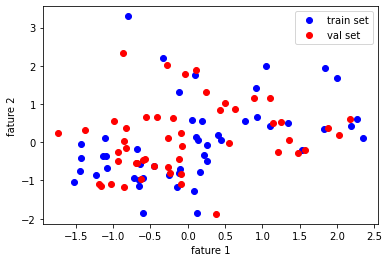

In [78]:
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val set'])
plt.show()

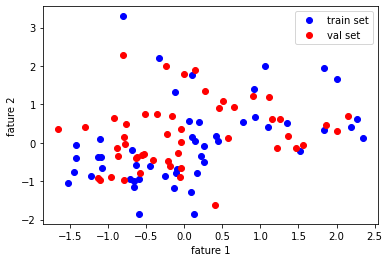

In [79]:
x_val_scaled = (x_val - train_mean) /train_std
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val set'])
plt.show()

In [80]:
layer2.score(x_val_scaled, y_val)

0.978021978021978